# **Heart Disease Study Notebook**

## Objectives

* Answer business requirement 1:
    * The client is interested to understand how different variables affect Heart Disease presence in patients.

## Inputs

* outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build the Streamlit App 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv")
    )
df.head(5)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


---

# Data Exploration

* We are interested in getting more familiar with the dataset, checking variable type and distribution, missing levels and what these variables mean in a clinical context

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From Pandas profiling report we observe:

* Age appears to be unnaturally distributed. This might point to a foult in data records
* There's a lot more male patients than female patients (about 3/1 ratio)
* There's '0' values in total cholesterol count (serumcholestrol). This can't be accurate as low colesterol level is leathal. We will deal with this in Data Cleaning notebook

---

# Correlation Study

All columns contain numbers, therefore we don't need to do any data type convertions

We use .corr() for spearman and pearson methods, and investigate the top 10 correlations

* We know this command returns a pandas series and the first item is the correlation between target and target, which happens to be 1, so we exclude that with [1:]
* We sort values considering the absolute value, by setting key=abs

### Spearman Method

In [6]:
corr_spearman = df.corr(method='spearman')['target'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

slope                0.809480
chestpain            0.566892
noofmajorvessels     0.505871
restingBP            0.485415
restingrelectro      0.417025
fastingbloodsugar    0.303233
serumcholestrol      0.248631
maxheartrate         0.202134
oldpeak              0.101373
exerciseangia       -0.039874
Name: target, dtype: float64

### Pearson Method

In [7]:
corr_pearson = df.corr(method='pearson')['target'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

slope                0.797358
chestpain            0.554228
noofmajorvessels     0.489866
restingBP            0.482387
restingrelectro      0.426837
fastingbloodsugar    0.303233
maxheartrate         0.228343
serumcholestrol      0.195340
oldpeak              0.098053
exerciseangia       -0.039874
Name: target, dtype: float64

* For both methods, we notice same variables in the top six corellations
* There's a strong correlation between target and a slope variable (around 0.8)
* A moderate correlation between target and chestpain, noofmajorvessels, restingBP, restingelectro is also observed (0.3-0.5)

In [8]:
top_n = 6
combined_list = corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list()
significant_variables = set(combined_list)
print(significant_variables)

{'fastingbloodsugar', 'restingBP', 'chestpain', 'slope', 'restingrelectro', 'noofmajorvessels'}


We will be using these six variables for our study. We will also add serumcholestrol variable as it is requered to verify Hypothesis #2.

We will investigate if a Heart Disease presence is affected by:
* Slope of the peak exercise ST segment (slope)
* Chest pain type (chestpain)
* Number of major vessels affected (noofmajorvessels)
* Resting blood pressure (restingBP)
* Resting electrocardiogram results (restingrelectro)
* Fasting blood sugar (fastingbloodsugar)
* Serum cholesterol level (serumcholestrol)


In [9]:
vars_to_study = ['slope', 'chestpain', 'noofmajorvessels', 'restingBP', 'restingrelectro', 'fastingbloodsugar', 'serumcholestrol']
vars_to_study

['slope',
 'chestpain',
 'noofmajorvessels',
 'restingBP',
 'restingrelectro',
 'fastingbloodsugar',
 'serumcholestrol']

---

# EDA on Selected Variables

In [10]:
df_eda = df.filter(vars_to_study + ['target'])
df_eda.head(3)

,slope,chestpain,noofmajorvessels,restingBP,restingrelectro,fastingbloodsugar,serumcholestrol,target
0,3,2,3,171,1,0,0,1
1,1,0,1,94,1,0,229,0
2,1,2,0,133,0,0,142,0


* We plot the distribution (numerical and  categorical) coloured by target.

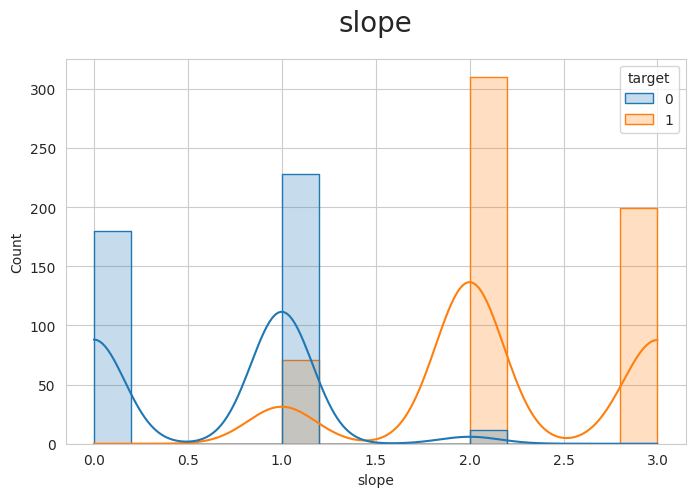

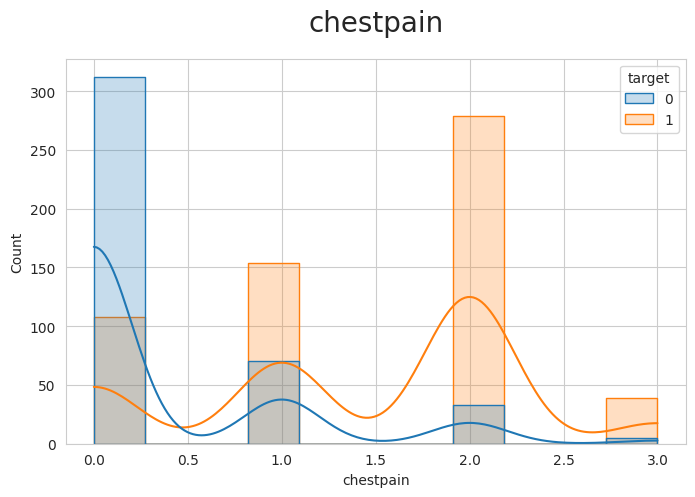

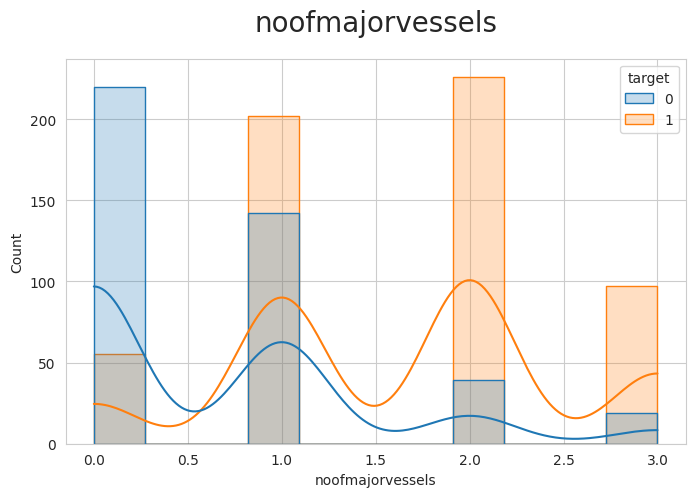

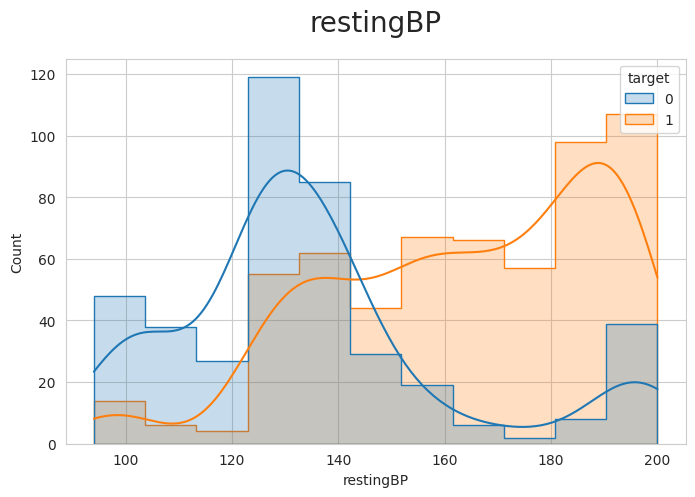

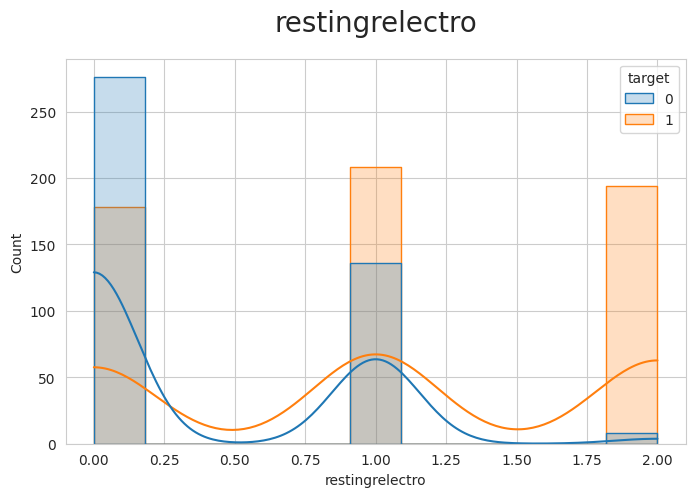

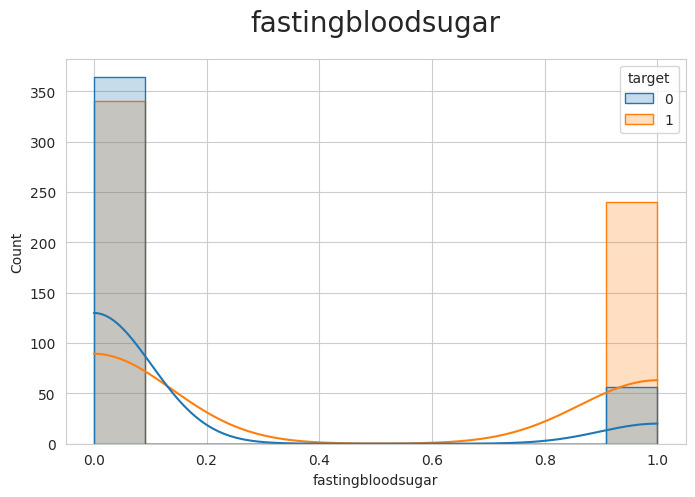

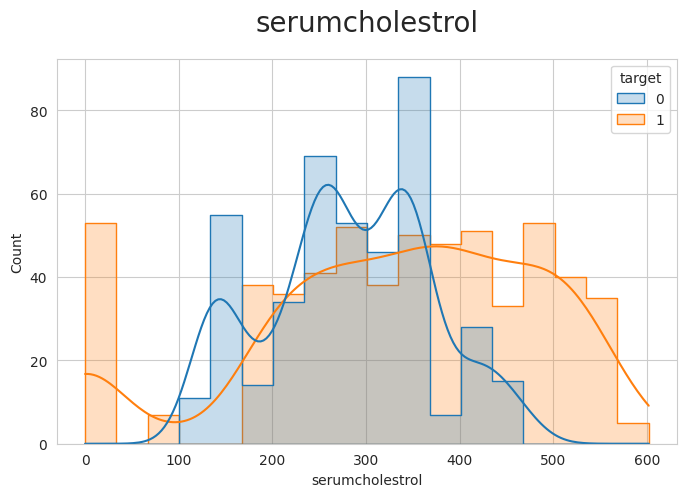

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def plot_numerical(df, col, target_var):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue=target_var, kde=True, element="step")
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


target_var = 'target'
for col in vars_to_study:
    plot_numerical(df_eda, col, target_var)
    print("\n\n")

## Paraller Plot

* Create a separate DataFrame and transform age (numerical) into bins (categorical) for visualising at parallel_categories() plot

In [12]:
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np
age_map = [-np.Inf, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.Inf]
disc = ArbitraryDiscretiser(binning_dict={'age': age_map})
df_parallel = disc.fit_transform(df)
df_parallel.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,6,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,3,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,5,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,4,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,2,1,1,199,0,0,2,136,0,5.3,3,2,1


In [13]:
disc.binner_dict_['age']

[-inf, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, inf]

* Create a map to replace the age variable with more informative levels.

In [14]:
n_classes = len(age_map) - 1
classes_ranges = disc.binner_dict_['age'][1:-1]

labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        labels_map[n] = f"20-{classes_ranges[0]}"
    elif n == n_classes-1:
        labels_map[n] = f"{classes_ranges[-1]}-80"
    else:
        labels_map[n] = f"{classes_ranges[n-1]}-{classes_ranges[n]}"

labels_map

{0: '20-25',
 1: '25-30',
 2: '30-35',
 3: '35-40',
 4: '40-45',
 5: '45-50',
 6: '50-55',
 7: '55-60',
 8: '60-65',
 9: '65-70',
 10: '70-75',
 11: '75-80'}

* Replace using .replace()

In [15]:
df_parallel['age'] = df_parallel['age'].replace(labels_map)
df_parallel.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,50-55,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,35-40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,45-50,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,40-45,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,30-35,1,1,199,0,0,2,136,0,5.3,3,2,1


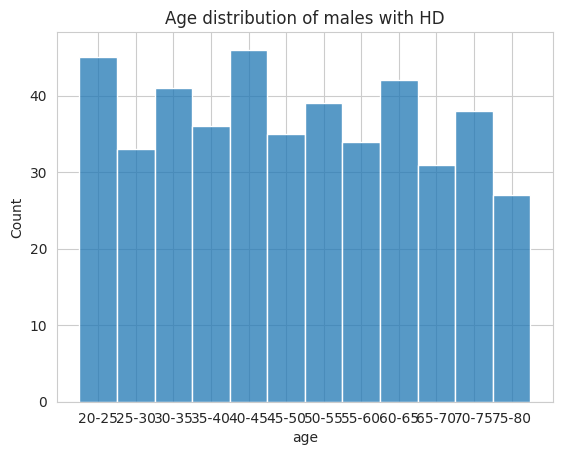

In [20]:
df_age_hd = df_parallel[df_parallel['target'] == 1]
df_male_age_hd = df_age_hd[df_age_hd['gender'] == 1]
df_sorted_male_age = df_male_age_hd.sort_values(by=['age'], axis=0)
sns.histplot(df_sorted_male_age['age'], width=1.4)
plt.title('Age distribution of males with HD')
plt.show()

---

# Conclusions and Next Steps

In this notebook we fullfilled Business Requirement #1 - data visualisations of the correlated variables against the target variable.
We also gain insight on Hypothesis #2 and Hypothesis #3.

To conclude:

* Almost all the patients who had the slope of the peak exercise at 'flat' and 'downslope' values had Heart Disease
* Most of the patients who reported non-anginal or asymptomatic pain had Heart Disease
* Most of the patients who had number of vessels affected set at values 2 and 3 had Heart Disease
* Patients with Heart Disease typically had a higher resting blood preasure
* Most patients with probable or definite left ventricular hypertrophy value in electrocardiogram results had Heart Disease
* Patients who had their fasting blood sugar levers above 120 mg/dl were more likely to have a Heart Disease
* All patients with total cholesterol levels above 470 mg/dl had Heart Disease